# Imports and Definitions

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import pytorch_lightning as pl
from collections import defaultdict, OrderedDict
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, transforms
from torchinfo import summary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, BatchSizeFinder, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import glob

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.model_selection import train_test_split
import mlflow

import hashlib
from datetime import datetime
from zoneinfo import ZoneInfo
import json

from config import Config

# Download Data

In [30]:
import os
import urllib.request
import tarfile

# File URLs
urls = [
    "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz",
    "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz"
]

# Create destination folder
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

def download_and_extract(url, destination_folder):
    """Downloads a .tar.gz file and extracts it"""
    
    filename = url.split("/")[-1]
    filepath = os.path.join(destination_folder, filename)
    folder_name = filename.split(".")[0]
    # Check if directory already exists and has content
    if os.path.exists(os.path.join(destination_folder, folder_name)) and \
    os.listdir(os.path.join(destination_folder, folder_name)):
        print(f"✓ Directory '{destination_folder}' already exists with content. Skipping download.")
        return
    
    # Download
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filepath)
    print(f"✓ Downloaded: {filename}")
    
    # Extract
    print(f"Extracting {filename}...")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall(path=destination_folder)
    print(f"✓ Extracted: {filename}")
    
    # Remove the .tar.gz file (optional)
    os.remove(filepath)
    print(f"✓ Temporary file removed: {filename}\n")

# Process each URL
for url in urls:
    download_and_extract(url, output_dir)

print("Completed! Files are in the 'download_data' folder")
print(f"Contents: {os.listdir(output_dir)}")

✓ Directory 'data' already exists with content. Skipping download.
✓ Directory 'data' already exists with content. Skipping download.
Completed! Files are in the 'download_data' folder
Contents: ['annotations.tar.gz', 'images.tar.gz', 'images', 'annotations', 'annotations.txt', 'annotations.csv', '.ipynb_checkpoints', 'labels.json']


In [31]:
df = pd.read_csv(
    f"{output_dir}/annotations/list.txt",  # Replace with your file path
    sep=' ',
    skiprows=6,  # Skip the 6 comment lines (including the header line)
    names=['Image', 'ID', 'Species', 'Breed_id'],  # Define column names
    engine='python'
).drop(columns=["ID","Breed_id"])
df['Species'] -= 1
df.to_csv(f"{output_dir}/annotations.csv", index=False)

print(df.head())
print(f"\nShape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")

            Image  Species
0  Abyssinian_100        0
1  Abyssinian_101        0
2  Abyssinian_102        0
3  Abyssinian_103        0
4  Abyssinian_104        0

Shape: (7349, 2)

Column names: ['Image', 'Species']


In [4]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, images_dir, df, transforms = None):
        
        self.images_dir = images_dir
        self.transforms = transforms
        self.df = df
        label_map = {'0':'cat', '1':'dog'}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):        
        # Load img
        img_path = os.path.join(self.images_dir, self.df.iloc[idx]['Image'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)

        label = int(self.df.iloc[idx]['Species'])
        
        return image, label

## DataModule

In [5]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir='data', batch_size=64, num_workers=2):
        super().__init__()
        self.save_hyperparameters()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def setup(self, stage=None):
        images_dir = os.path.join(self.data_dir, 'images')

        df = pd.read_csv("data/annotations.csv")

        train_df, temp_df = train_test_split(
            df,
            test_size=0.20,
            stratify=df["Species"],
            random_state=42,
            shuffle=True
        )
        
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.50,
            stratify=temp_df["Species"],
            random_state=42,
            shuffle=True
        )

        transforms = MobileNet_V2_Weights.IMAGENET1K_V1.transforms()
        
        # Crear datasets filtrados por set
        self.train_ds = CatsAndDogsDataset(
            images_dir = images_dir, 
            df = train_df, 
            transforms = transforms
        )
        
        self.val_ds = CatsAndDogsDataset(
            images_dir = images_dir, 
            df = val_df, 
            transforms = transforms
        )
        
        self.test_ds = CatsAndDogsDataset(
            images_dir = images_dir, 
            df = test_df, 
            transforms = transforms
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_ds, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers
        )

    

## LightningModule

In [6]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        # Configure ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',           # Minimize the monitored metric
            factor=0.1,          # Multiply LR by this factor when reducing
            patience=5,          # Number of epochs with no improvement before reducing LR
            threshold=0.01,      # Threshold for measuring improvement
            threshold_mode='rel', # 'rel' for relative change, 'abs' for absolute
            cooldown=0,          # Number of epochs to wait before resuming normal operation
            min_lr=1e-6,         # Lower bound on the learning rate
            eps=1e-8             # Minimal decay applied to lr
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Metric to monitor
                'interval': 'epoch',     # Update scheduler after each epoch
                'frequency': 1,          # Check metric every epoch
                'strict': True,          # Enforce that monitored metric exists
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        y_np = y.detach().cpu().numpy()
        preds_np = preds.detach().cpu().numpy()
        f1 = f1_score(y_np, preds_np, average='macro')
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_f1_score', f1, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['f1_score'] += f1
        self.training_step_outputs['steps'] += 1

        # Calculate F1 score (use 'macro' for multiclass)
        
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        
        y_np = y.detach().cpu().numpy()
        preds_np = preds.detach().cpu().numpy()
        f1 = f1_score(y_np, preds_np, average='macro')
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_f1_score', f1, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['f1_score'] += f1
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        avg_f1 = self.training_step_outputs['f1_score'] / self.training_step_outputs['steps']
        
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        
        mlflow.log_metric("train_loss", avg_loss.item(), step=self.current_epoch)
        mlflow.log_metric("train_f1_score", avg_f1, step=self.current_epoch)
        
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        avg_f1 = self.validation_step_outputs['f1_score'] / self.validation_step_outputs['steps']
        
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")

        mlflow.log_metric("val_loss", avg_loss.item(), step=self.current_epoch)
        mlflow.log_metric("val_f1_score", avg_f1, step=self.current_epoch)
        
        self.validation_step_outputs.clear()

## Useful functions

### EDA functions

In [7]:
def plot_class_distribution(figsize = (12, 7), set_name = None, filename = None):
    # Load the CSV file
    df = pd.read_csv("data/annotations.csv")

    train_df, temp_df = train_test_split(
        df,
        test_size=0.20,
        stratify=df["Species"],
        random_state=42,
        shuffle=True
    )
    
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        stratify=temp_df["Species"],
        random_state=42,
        shuffle=True
    )

    if set_name is not None:
        if set_name == 'train':
            df_filtered = train_df
        elif set_name == 'val':
            df_filtered = val_df
        elif set_name == 'test':
            df_filtered = test_df
    else:
        df_filtered = df
    
    # Count classes
    class_counts = df_filtered['Species'].value_counts().sort_index()
    
    # Map labels to disease names
    labels = ["Cat", "Dog"]
    counts = class_counts.values
    
    # Calculate percentages
    total = counts.sum()
    percentages = (counts / total) * 100
    
    # Create figure with custom style
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    
    # Create color palette
    colors = sns.color_palette("husl", len(labels))
    
    # Create bars
    bars = plt.bar(range(len(labels)), counts, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Customize plot
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
    if set_name is not None:
        plt.title(f'Class Distribution - {set_name.capitalize()} Set', 
                  fontsize=16, fontweight='bold', pad=20)
    else:
        plt.title(f'Class Distribution', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis labels
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=11)
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add total count in the corner
    # plt.text(0.98, 0.98, f'Total: {total} images', 
    #          transform=plt.gca().transAxes,
    #          fontsize=12, fontweight='bold',
    #          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
    #          verticalalignment='top', horizontalalignment='right')
    
    plt.tight_layout()
    
    # Save if filename provided
    if filename:
        plt.savefig(filename, dpi=80)
    
    plt.show()

In [8]:
def plot_random_samples(dataset_split=None, samples_per_class=3, figsize=(15, 10), seed=42, filename=None):
    """
    Plot random samples from each class in a fancy grid layout.

    Parameters:
    -----------
    dataset_split : str
        Dataset split to visualize ('train', 'val', or 'test')
    samples_per_class : int, default=3
        Number of random samples to show per class
    figsize : tuple, default=(15, 10)
        Figure size (width, height)
    seed : int, default=42
        Random seed for reproducibility
    """
    # Set random seed
    np.random.seed(seed)

    # Load the annotations file
    annotations_df = pd.read_csv("data/annotations.csv")

    # Split into train / val / test
    train_df, temp_df = train_test_split(
        annotations_df,
        test_size=0.20,
        stratify=annotations_df["Species"],
        random_state=42,
        shuffle=True
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        stratify=temp_df["Species"],
        random_state=42,
        shuffle=True
    )

    # Filter by dataset split
    if dataset_split is not None:
        if dataset_split == 'train':
            filtered_df = train_df
        elif dataset_split == 'val':
            filtered_df = val_df
        elif dataset_split == 'test':
            filtered_df = test_df
        else:
            raise ValueError("dataset_split must be 'train', 'val', or 'test'")
    else:
        filtered_df = annotations_df

    # Images folder path
    images_dir = os.path.join('data', 'images')

    # Get unique classes
    classes = sorted(filtered_df['Species'].unique())
    num_classes = len(classes)

    # Create figure with subplots
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=figsize)

    # Handle case of single row
    if num_classes == 1:
        axes = axes.reshape(1, -1)

    # Color palette for borders
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

    # Class label mapping
    label_map = {'0': 'cat', '1': 'dog'}

    # Plot samples for each class
    for class_idx, class_label in enumerate(classes):
        # Get all images for this class
        class_image_ids = filtered_df[filtered_df['Species'] == class_label]['Image'].values + ".jpg"

        # Randomly sample
        if len(class_image_ids) >= samples_per_class:
            sampled_images = np.random.choice(class_image_ids, samples_per_class, replace=False)
        else:
            sampled_images = class_image_ids

        # Plot each sample
        for sample_idx, img_name in enumerate(sampled_images):
            ax = axes[class_idx, sample_idx]

            # Load and display image
            img_path = os.path.join(images_dir, img_name)
            try:
                img = Image.open(img_path)
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, f'Error loading\n{img_name}',
                        ha='center', va='center', fontsize=8)

            # Remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Add colored border
            for spine in ax.spines.values():
                spine.set_edgecolor(colors[class_idx])
                spine.set_linewidth(3)

            # Add class label only for first column
            if sample_idx == 0:
                class_name = label_map[str(class_label)]
                ax.set_ylabel(class_name, fontsize=11, fontweight='bold',
                              rotation=90, labelpad=10)

            # Add image filename at the bottom
            image_id = img_name.split('.')[0]
            ax.set_xlabel(image_id, fontsize=8, style='italic')

    # Add main title
    if dataset_split is not None:
        fig.suptitle(f'Random Samples from Cats vs Dogs Dataset - {dataset_split.capitalize()} Set',
                     fontsize=16, fontweight='bold', y=0.995)

    # Add legend for classes
    legend_labels = [label_map[str(label)] for label in classes]

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc=colors[i], edgecolor='black', linewidth=1.5, label=legend_labels[i])
        for i in range(len(classes))
    ]

    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=num_classes,
        bbox_to_anchor=(0.5, -0.02),
        fontsize=10,
        frameon=True,
        fancybox=True,
        shadow=True
    )

    plt.tight_layout()

    # Save if filename provided
    if filename:
        plt.savefig(filename, dpi=80)

    plt.show()


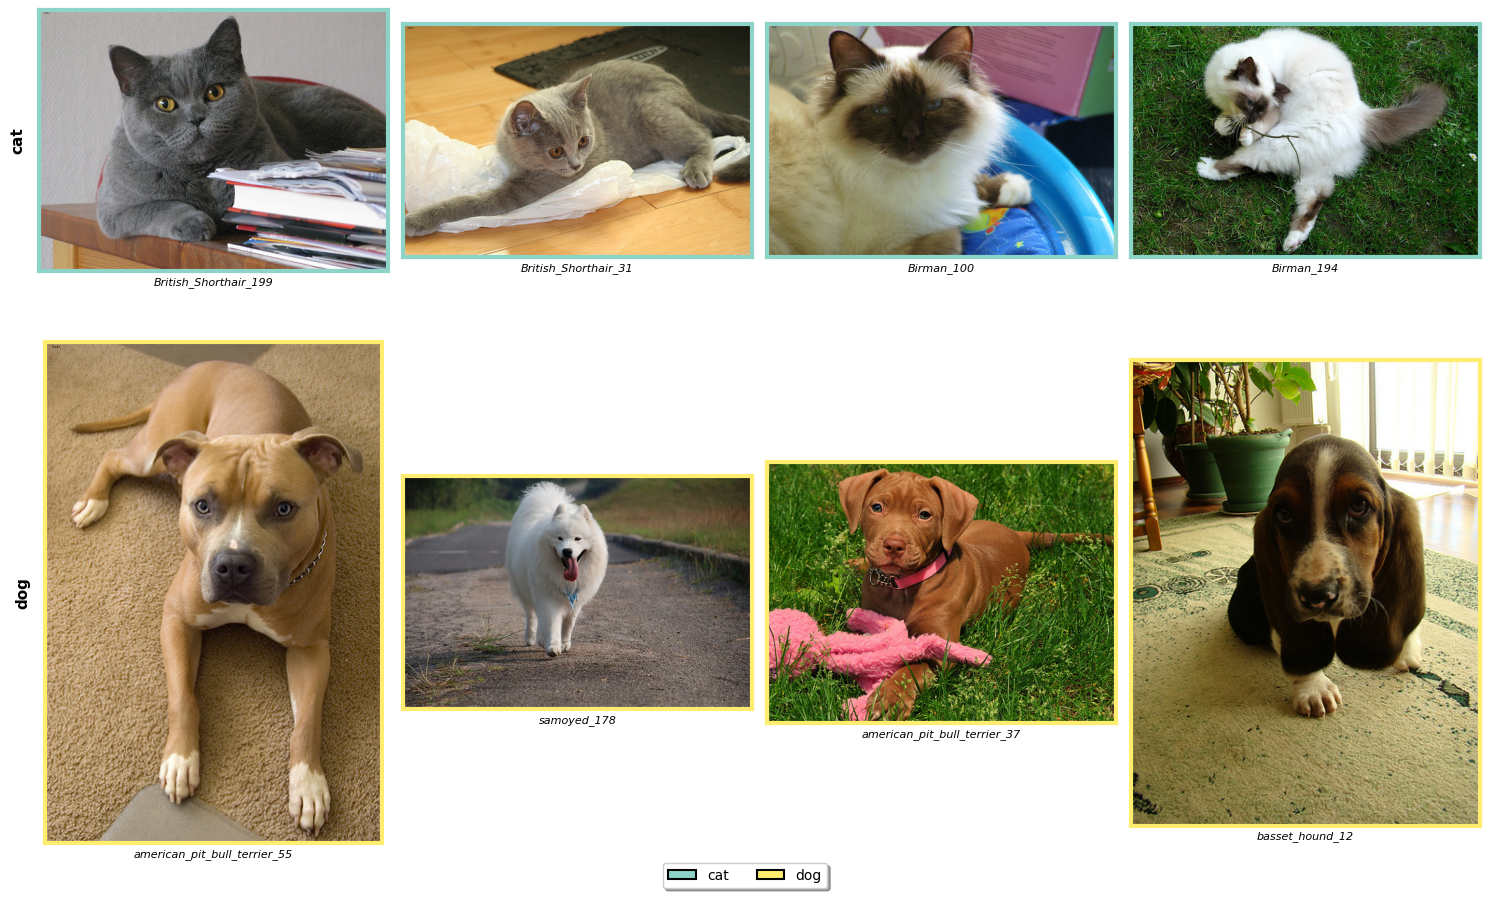

In [9]:
plot_random_samples(samples_per_class = 4)

### Performance functions

In [10]:
def plot_cm(trainer, data_module, filename=None):
    """
    Plot confusion matrix from trained model predictions.
    
    Parameters:
    -----------
    trainer : pytorch_lightning.Trainer
        The trained PyTorch Lightning trainer object
    data_module : pytorch_lightning.LightningDataModule
        The data module containing test data
    filename : str, optional
        If provided, saves the plot to this filename
    """
    # Extract the model from the trainer
    model = trainer.lightning_module
    label_map = {'0': 'cat', '1': 'dog'}

    class_labels = []
    for label in range(len(label_map)):
        label_name = label_map[str(label)]
        class_labels.append(label_name)

    # Use GPU if available and set model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    y_trues = []
    y_hats = []

    # Iterate through the dataloader and collect predictions and true labels
    print("Generating predictions...")
    for x, y_true in data_module.test_dataloader():
        x = x.to(device)
        with torch.no_grad():
            logits = model(x)
            # Apply softmax and take argmax to get predicted class indices
            preds = logits.softmax(dim=1).argmax(dim=1).cpu()

        y_hats.append(preds)
        # Ensure true labels are on CPU before concatenation
        y_trues.append(y_true.cpu())

    # Concatenate and convert to numpy arrays for sklearn and matplotlib
    y_trues = torch.cat(y_trues).numpy()
    y_hats = torch.cat(y_hats).numpy()

    # Calculate F1 score (use 'macro' for multiclass)
    f1 = f1_score(y_trues, y_hats, average='macro')
    print(f'F1 Score (macro): {f1:.4f}')

    mlflow.log_metric("test_f1_score", f1)
    
    # Build confusion matrix
    num_classes = len(class_labels)
    labels = np.arange(num_classes)
    cm = confusion_matrix(y_trues, y_hats, labels=labels)

    # Normalize by row (true label) to get per-class percentages
    with np.errstate(all='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_row_norm = np.divide(cm.astype(float), row_sums, where=row_sums != 0)
        cm_row_norm = np.nan_to_num(cm_row_norm)  # replace NaN/inf with 0 for empty rows

    # Create annotations that include both count and percentage
    nrows, ncols = cm.shape
    annot = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f"{cm[i, j]}\n{cm_row_norm[i, j]*100:.2f}%"

    # Plot: normalized confusion matrix with count + percentage per cell
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_row_norm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Normalized value'})
    
    plt.title(f"Confusion Matrix (F1 Score Macro: {f1:.4f})", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
    plt.ylabel("True Labels", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename, dpi=80)
        print(f"Confusion matrix saved to {filename}")
    
    plt.show()

In [11]:
def plot_loss_curves(trainer, ylim = (0,1), filename=None):

    sns.set_style(style='ticks')
    metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
    metric_df = metric_df.groupby('epoch', as_index=False).first()
    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    metric_df.train_loss.plot(ax=ax, label='train')
    metric_df.val_loss.plot(ax=ax, label='val')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    
    # Set x-axis ticks to show every epoch
    epochs = metric_df['epoch'].dropna().astype(int)
    ax.set_xticks(epochs)
    ax.set_xticklabels(epochs)
    
    # Rotate labels if there are many epochs
    if len(epochs) > 20:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.legend()
    plt.ylim(ylim)
    
    if filename != None:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename, dpi=80)
    
    plt.show()

# EDA

## Class Distribution over predefined sets

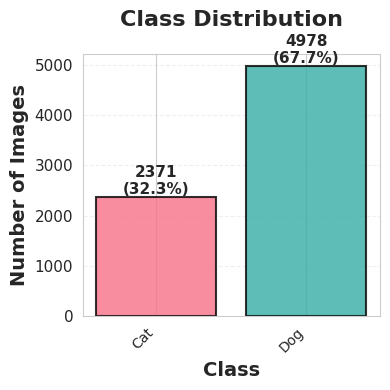

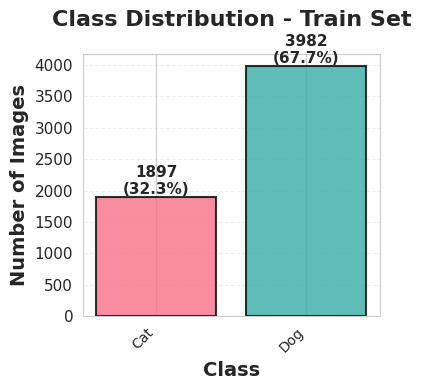

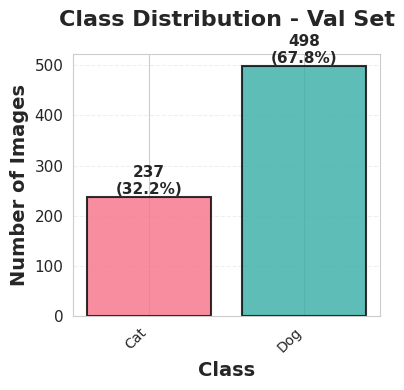

In [12]:
plot_class_distribution(figsize=(4, 4))
plot_class_distribution(set_name = "train", figsize=(4, 4))
plot_class_distribution(set_name = "val", figsize=(4, 4))
plot_class_distribution(set_name = "test", figsize=(4, 4))
# os.path.join(os.getcwd(), 'figures', 'predefined_train_set_split_class_dist.pdf')

The predefined set splits are equally distributed, so we will use them. The problem is that the sets are very imbalanced on CMD class. We should downsample CMD class by a factor of 5 in order to balance class distribution on train set.

## Random Samples from each Class

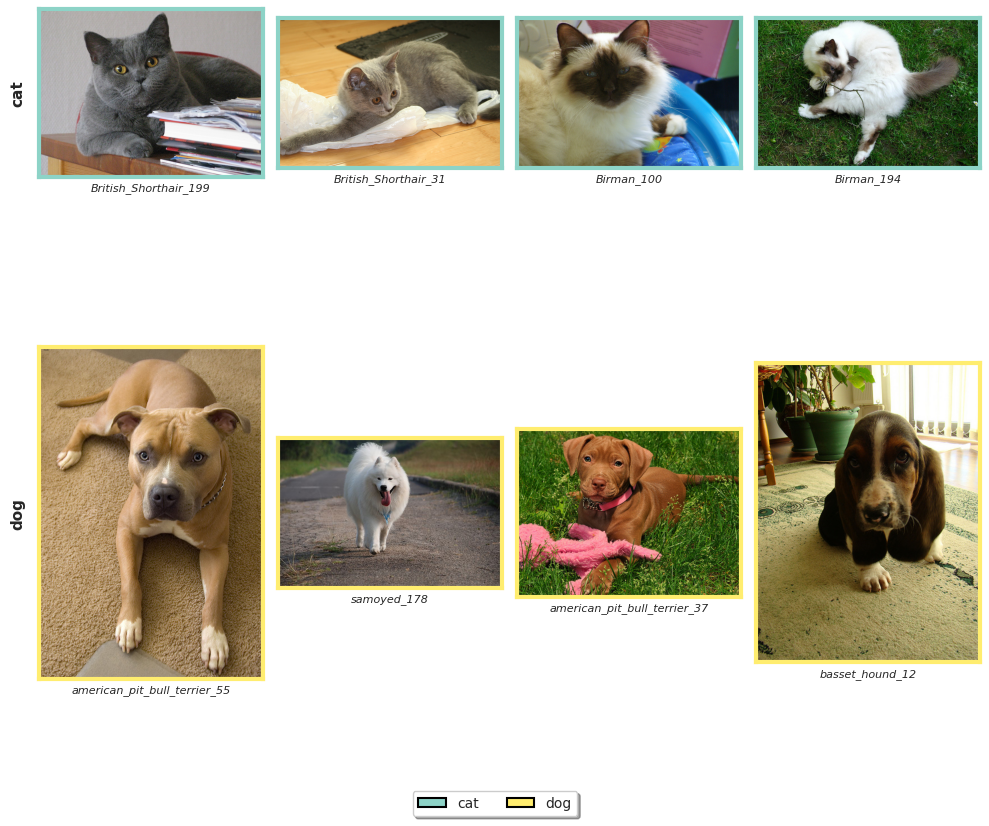

In [13]:
plot_random_samples(
    samples_per_class=4,
    figsize=(10, 10),
    seed=42,
    # filename=os.path.join(os.getcwd(), 'figures', 'random_samples_train_seed42.pdf')
)

# Transfer Learning Study

## Train / Val / Test splits
As we have seen previously, there is a huge imbalance coming from CMD class. So, we will downsample that class on Train set.

## Pretrained model + Feature Extraction (freeze all but classification head)

In [14]:
json_data = {'0': 'cat', '1': 'dog'}

json_path = "data/labels.json"

with open(json_path, "w") as f:
    json.dump(json_data, f, indent=4)

In [15]:
def train_and_track_model(
    experiment_name = "torchvision.mobilenet_v2 for cats_and_dogs classification experiment",
    run_name = "default",
    random_seed = 42,
    dataset_name = "Oxford-IIIT Pet dataset",
    dataset_link = "https://www.robots.ox.ac.uk/~vgg/data/pets/",
    dataset_labels = "annotations.csv",
    model_name = "cats_and_dogs_mobilenet_v2",
    model_weights = "IMAGENET1K_V1",
    lr = 1e-3,
    min_delta = 0.01,
    patience = 10,
    max_epochs = 100,
    batch_size = 1024,
    num_workers = 2,
    json_path = "data/labels.json",
    csv_path = "data/annotations.csv"
):
    mlflow.set_experiment(experiment_name)
    
    # Set random seed for reproducibility
    NUM_CLASSES = 2
    
    # TOUCHABLE:
    if run_name == "default":
        actual_date = datetime.now(ZoneInfo("Europe/Madrid")).strftime("%H%M%d%m%Y")
        unique_hash = hashlib.sha256(os.urandom(32)).hexdigest()[:4]
        
        run_name = f"mobilenet_v2_{actual_date}_{unique_hash}"
    
    with mlflow.start_run(run_name = run_name):
        # Register params
        mlflow.log_params({
            "run_name": run_name,
            "random_seed": random_seed,
            "dataset_name": dataset_name,
            "dataset_link": dataset_link,
            "dataset_labels": dataset_labels,
            "model_weights": model_weights,
            "lightning_module_lr": lr,
            "early_stop_min_delta": min_delta,
            "early_stop_patience": patience,
            "trainer_max_epochs" : max_epochs,
            "data_module_batch_size": batch_size,
            "data_module_num_workers": num_workers,
        })
    
        if json_path:
            mlflow.log_artifact(json_path)
            
        if csv_path:
            mlflow.log_artifact(csv_path)
        
        pl.seed_everything(seed = random_seed, workers = True)
        
        # Instantiate the model, freeze all layers and adapt the first layer
        model = mobilenet_v2(weights = model_weights)
        
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False
        
        # Replace the final layer for our specific task (e.g., 10 classes)
        num_in_feat = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_in_feat, NUM_CLASSES)
        
        # Wrap the model inside a LightningModule. 
        lightning_module = LightningModule(model, lr = lr)
        
        # Define a CSV logger to store training/validation metrics in CSV format.
        csv_logger = CSVLogger(save_dir = f"{os.getcwd()}/{model_name}_logs", name = model_name)
        
        # Define callbacks
        learning_rate_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
        
        early_stop_callback = EarlyStopping(
            monitor = "val_loss",
            min_delta = min_delta,
            patience = patience,
            verbose = False,
            mode = "min"
        )
        
        model_checkpointing = ModelCheckpoint(
            dirpath = os.path.join(os.getcwd(), f"{model_name}_checkpoints"),
            filename = model_name + "-{epoch:02d}-{val_loss:.2f}",
            monitor = 'val_loss',
            verbose = True,
            save_last = True,
            mode = 'min'
        )
        
        trainer = pl.Trainer(
            max_epochs = max_epochs,
            logger = [csv_logger], #mlflow_logger],
            callbacks = [
                learning_rate_monitor,
                early_stop_callback,
                model_checkpointing
            ]
        )
        
        data_module = DataModule(batch_size = batch_size, num_workers = num_workers)
        
        # Train the model with the trainer, passing the core LightningModule and data module.
        trainer.fit(lightning_module, data_module)

        loss_curves_file = os.path.join(os.getcwd(), f'{model_name}_figures', f'{model_name}_loss_curves.pdf')
        plot_loss_curves(
            trainer,
            ylim = (0.03, 0.1),
            filename = loss_curves_file
        )

        cm_file = os.path.join(os.getcwd(), f'{model_name}_figures', f'{model_name}_confusion_matrix.pdf')
        plot_cm(
            trainer,
            data_module,
            filename = cm_file
        )

        mlflow.log_artifact(loss_curves_file)
        mlflow.log_artifact(cm_file)
        
        model_info = mlflow.pytorch.log_model(
            pytorch_model = lightning_module.model, 
            name = "model",
            registered_model_name=model_name
        )

In [16]:
# train_and_track_model(
#     experiment_name = Config.EXPERIMENT_NAME,
#     run_name = Config.RUN_NAME,
#     random_seed = Config.RANDOM_SEED,
#     dataset_name = Config.DATASET_NAME,
#     dataset_link = Config.DATASET_LINK,
#     dataset_labels = Config.DATASET_LABELS,
#     model_name = Config.MODEL_NAME,
#     model_weights = Config.MODEL_WEIGHTS,
#     lr = Config.LR,
#     min_delta = Config.MIN_DELTA,
#     patience = Config.PATIENCE,
#     max_epochs = Config.MAX_EPOCHS,
#     batch_size = Config.BATCH_SIZE,
#     num_workers = Config.NUM_WORKERS,
#     json_path = Config.JSON_PATH,
#     csv_path = Config.CSV_PATH
# )

# EXPERIMENTS

## LEARNING RATE

2025/12/14 18:58:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/14 18:58:36 INFO mlflow.store.db.utils: Updating database tables
2025/12/14 18:58:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/14 18:58:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/14 18:58:36 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/14 18:58:36 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/14 18:58:36 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/14 18:58:36 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/14 18:58:36 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/14 18:58:37 INFO alembic.runtime.migration: Running 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6844


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 6: 'val_loss' reached 0.23800 (best 0.23800), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.24.ckpt' as top 1


Average validation loss for epoch 0: 0.2380
Average training loss for epoch 0: 3.7913


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 12: 'val_loss' reached 0.15069 (best 0.15069), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.15.ckpt' as top 1


Average validation loss for epoch 1: 0.1507
Average training loss for epoch 1: 1.0120


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 18: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.1773
Average training loss for epoch 2: 0.4515


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 24: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.2711
Average training loss for epoch 3: 0.2015


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 30: 'val_loss' reached 0.10595 (best 0.10595), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.11.ckpt' as top 1


Average validation loss for epoch 4: 0.1060
Average training loss for epoch 4: 0.2086


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 36: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.1228
Average training loss for epoch 5: 0.1621


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 42: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.1240
Average training loss for epoch 6: 0.0962


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 48: 'val_loss' reached 0.09644 (best 0.09644), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=07-val_loss=0.10.ckpt' as top 1


Average validation loss for epoch 7: 0.0964
Average training loss for epoch 7: 0.1044


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 54: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.0974
Average training loss for epoch 8: 0.0917


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 60: 'val_loss' reached 0.09634 (best 0.09634), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=09-val_loss=0.10.ckpt' as top 1


Average validation loss for epoch 9: 0.0963
Average training loss for epoch 9: 0.0823


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 66: 'val_loss' reached 0.08732 (best 0.08732), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=10-val_loss=0.09.ckpt' as top 1


Average validation loss for epoch 10: 0.0873
Average training loss for epoch 10: 0.0735


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 72: 'val_loss' reached 0.08098 (best 0.08098), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=11-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 11: 0.0810
Average training loss for epoch 11: 0.0742


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 78: 'val_loss' was not in top 1


Average validation loss for epoch 12: 0.0837
Average training loss for epoch 12: 0.0648


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 84: 'val_loss' reached 0.07791 (best 0.07791), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=13-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 13: 0.0779
Average training loss for epoch 13: 0.0507


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 90: 'val_loss' reached 0.07421 (best 0.07421), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=14-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 14: 0.0742
Average training loss for epoch 14: 0.0489


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 96: 'val_loss' reached 0.07378 (best 0.07378), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=15-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 15: 0.0738
Average training loss for epoch 15: 0.0462


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 102: 'val_loss' was not in top 1


Average validation loss for epoch 16: 0.0840
Average training loss for epoch 16: 0.0514


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 108: 'val_loss' reached 0.06796 (best 0.06796), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=17-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 17: 0.0680
Average training loss for epoch 17: 0.0458


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 18, global step 114: 'val_loss' reached 0.06722 (best 0.06722), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=18-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 18: 0.0672
Average training loss for epoch 18: 0.0437


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 19, global step 120: 'val_loss' was not in top 1


Average validation loss for epoch 19: 0.0704
Average training loss for epoch 19: 0.0360


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 20, global step 126: 'val_loss' reached 0.06498 (best 0.06498), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=20-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 20: 0.0650
Average training loss for epoch 20: 0.0364


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 21, global step 132: 'val_loss' reached 0.06447 (best 0.06447), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=21-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 21: 0.0645
Average training loss for epoch 21: 0.0537


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 22, global step 138: 'val_loss' was not in top 1


Average validation loss for epoch 22: 0.0728
Average training loss for epoch 22: 0.0352


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 23, global step 144: 'val_loss' was not in top 1


Average validation loss for epoch 23: 0.0646
Average training loss for epoch 23: 0.0384


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 24, global step 150: 'val_loss' reached 0.06410 (best 0.06410), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=24-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 24: 0.0641
Average training loss for epoch 24: 0.0256


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 25, global step 156: 'val_loss' was not in top 1


Average validation loss for epoch 25: 0.0648
Average training loss for epoch 25: 0.0285


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 26, global step 162: 'val_loss' was not in top 1


Average validation loss for epoch 26: 0.0658
Average training loss for epoch 26: 0.0301


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 27, global step 168: 'val_loss' was not in top 1


Average validation loss for epoch 27: 0.0651
Average training loss for epoch 27: 0.0229


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 28, global step 174: 'val_loss' was not in top 1


Average validation loss for epoch 28: 0.0647
Average training loss for epoch 28: 0.0201


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 29, global step 180: 'val_loss' reached 0.06164 (best 0.06164), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=29-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 29: 0.0616
Average training loss for epoch 29: 0.0246


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 30, global step 186: 'val_loss' was not in top 1


Average validation loss for epoch 30: 0.0632
Average training loss for epoch 30: 0.0178


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 31, global step 192: 'val_loss' was not in top 1


Average validation loss for epoch 31: 0.0633
Average training loss for epoch 31: 0.0193


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 32, global step 198: 'val_loss' was not in top 1


Average validation loss for epoch 32: 0.0650
Average training loss for epoch 32: 0.0232


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 33, global step 204: 'val_loss' was not in top 1


Average validation loss for epoch 33: 0.0673
Average training loss for epoch 33: 0.0228


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 34, global step 210: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


Average validation loss for epoch 34: 0.0660
Average training loss for epoch 34: 0.0185


Generating predictions...
F1 Score (macro): 0.9876
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


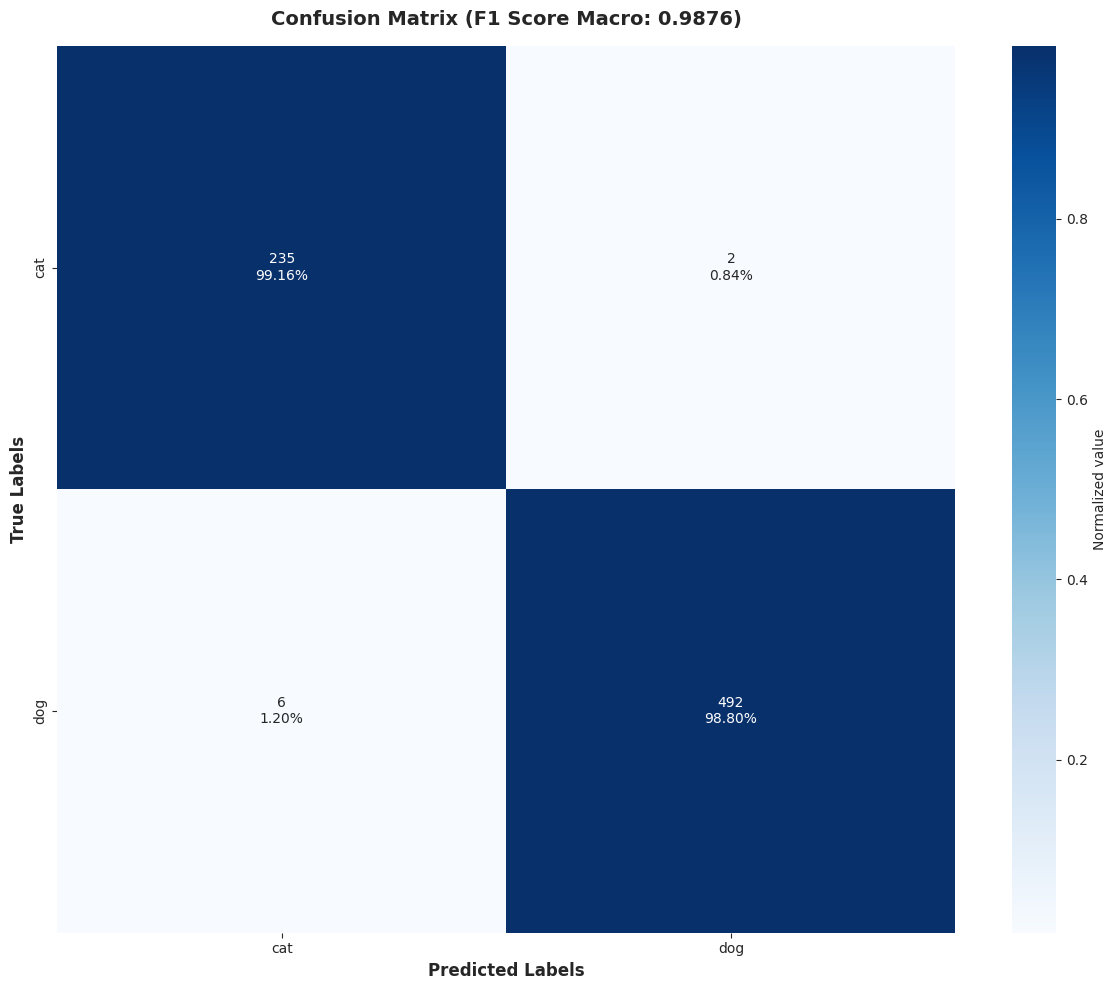

2025/12/14 19:12:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/14 19:12:40 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/14 19:12:40 INFO mlflow.store.db.utils: Updating database tables
2025/12/14 19:12:40 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/14 19:12:40 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Successfully registered model 'cats_and_dogs_mobilenet_v2'.
Created version '1' of model 'cats_and_dogs_mobilenet_v2'.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints exists and is not empty.
LOCAL_R

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6844


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 6: 'val_loss' reached 0.33412 (best 0.33412), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.33.ckpt' as top 1


Average validation loss for epoch 0: 0.3341
Average training loss for epoch 0: 0.5341


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 12: 'val_loss' reached 0.19145 (best 0.19145), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.19.ckpt' as top 1


Average validation loss for epoch 1: 0.1914
Average training loss for epoch 1: 0.2843


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 18: 'val_loss' reached 0.13892 (best 0.13892), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=02-val_loss=0.14.ckpt' as top 1


Average validation loss for epoch 2: 0.1389
Average training loss for epoch 2: 0.1816


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 24: 'val_loss' reached 0.10978 (best 0.10978), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=03-val_loss=0.11.ckpt' as top 1


Average validation loss for epoch 3: 0.1098
Average training loss for epoch 3: 0.1332


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 30: 'val_loss' reached 0.09494 (best 0.09494), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.09.ckpt' as top 1


Average validation loss for epoch 4: 0.0949
Average training loss for epoch 4: 0.1094


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 36: 'val_loss' reached 0.08497 (best 0.08497), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=05-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 5: 0.0850
Average training loss for epoch 5: 0.0927


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 42: 'val_loss' reached 0.07718 (best 0.07718), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=06-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 6: 0.0772
Average training loss for epoch 6: 0.0828


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 48: 'val_loss' reached 0.07218 (best 0.07218), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=07-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 7: 0.0722
Average training loss for epoch 7: 0.0766


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 54: 'val_loss' reached 0.06796 (best 0.06796), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=08-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 8: 0.0680
Average training loss for epoch 8: 0.0716


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 60: 'val_loss' reached 0.06396 (best 0.06396), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=09-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 9: 0.0640
Average training loss for epoch 9: 0.0677


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 66: 'val_loss' reached 0.06168 (best 0.06168), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=10-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 10: 0.0617
Average training loss for epoch 10: 0.0633


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 72: 'val_loss' reached 0.05886 (best 0.05886), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=11-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 11: 0.0589
Average training loss for epoch 11: 0.0613


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 78: 'val_loss' reached 0.05640 (best 0.05640), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=12-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 12: 0.0564
Average training loss for epoch 12: 0.0589


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 84: 'val_loss' reached 0.05460 (best 0.05460), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=13-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 13: 0.0546
Average training loss for epoch 13: 0.0554


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 90: 'val_loss' reached 0.05277 (best 0.05277), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=14-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 14: 0.0528
Average training loss for epoch 14: 0.0537


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 96: 'val_loss' reached 0.05114 (best 0.05114), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=15-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 15: 0.0511
Average training loss for epoch 15: 0.0510


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 102: 'val_loss' reached 0.05023 (best 0.05023), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=16-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 16: 0.0502
Average training loss for epoch 16: 0.0507


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 108: 'val_loss' reached 0.04857 (best 0.04857), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=17-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 17: 0.0486
Average training loss for epoch 17: 0.0503


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 18, global step 114: 'val_loss' reached 0.04733 (best 0.04733), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=18-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 18: 0.0473
Average training loss for epoch 18: 0.0504


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 19, global step 120: 'val_loss' reached 0.04621 (best 0.04621), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=19-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 19: 0.0462
Average training loss for epoch 19: 0.0465


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 20, global step 126: 'val_loss' reached 0.04524 (best 0.04524), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=20-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 20: 0.0452
Average training loss for epoch 20: 0.0453


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 21, global step 132: 'val_loss' reached 0.04441 (best 0.04441), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=21-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 21: 0.0444
Average training loss for epoch 21: 0.0457


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 22, global step 138: 'val_loss' reached 0.04358 (best 0.04358), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=22-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 22: 0.0436
Average training loss for epoch 22: 0.0427


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 23, global step 144: 'val_loss' reached 0.04273 (best 0.04273), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=23-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 23: 0.0427
Average training loss for epoch 23: 0.0424


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 24, global step 150: 'val_loss' reached 0.04185 (best 0.04185), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=24-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 24: 0.0419
Average training loss for epoch 24: 0.0408


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 25, global step 156: 'val_loss' reached 0.04118 (best 0.04118), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=25-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 25: 0.0412
Average training loss for epoch 25: 0.0408


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 26, global step 162: 'val_loss' reached 0.04048 (best 0.04048), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=26-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 26: 0.0405
Average training loss for epoch 26: 0.0415


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 27, global step 168: 'val_loss' reached 0.03979 (best 0.03979), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=27-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 27: 0.0398
Average training loss for epoch 27: 0.0382


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 28, global step 174: 'val_loss' reached 0.03919 (best 0.03919), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=28-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 28: 0.0392
Average training loss for epoch 28: 0.0376


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 29, global step 180: 'val_loss' reached 0.03857 (best 0.03857), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=29-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 29: 0.0386
Average training loss for epoch 29: 0.0375


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 30, global step 186: 'val_loss' reached 0.03807 (best 0.03807), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=30-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 30: 0.0381
Average training loss for epoch 30: 0.0375


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 31, global step 192: 'val_loss' reached 0.03767 (best 0.03767), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=31-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 31: 0.0377
Average training loss for epoch 31: 0.0362


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 32, global step 198: 'val_loss' reached 0.03715 (best 0.03715), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=32-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 32: 0.0372
Average training loss for epoch 32: 0.0366


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 33, global step 204: 'val_loss' reached 0.03667 (best 0.03667), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=33-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 33: 0.0367
Average training loss for epoch 33: 0.0352


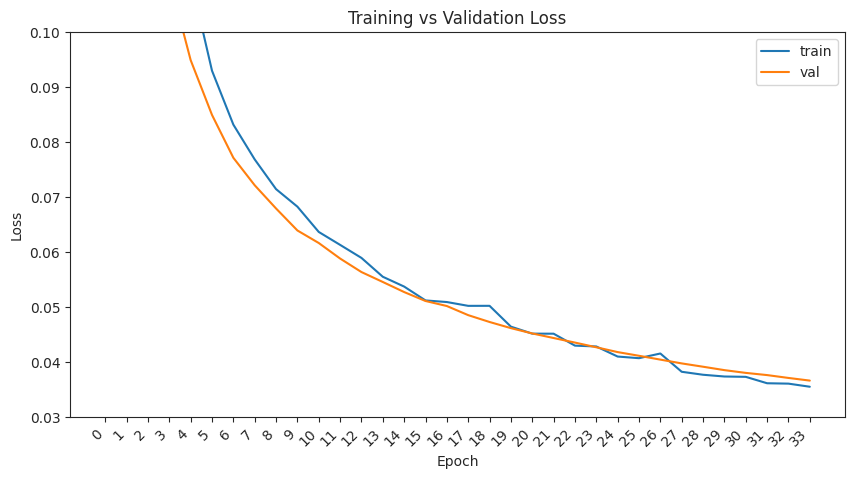

Generating predictions...
F1 Score (macro): 0.9891
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


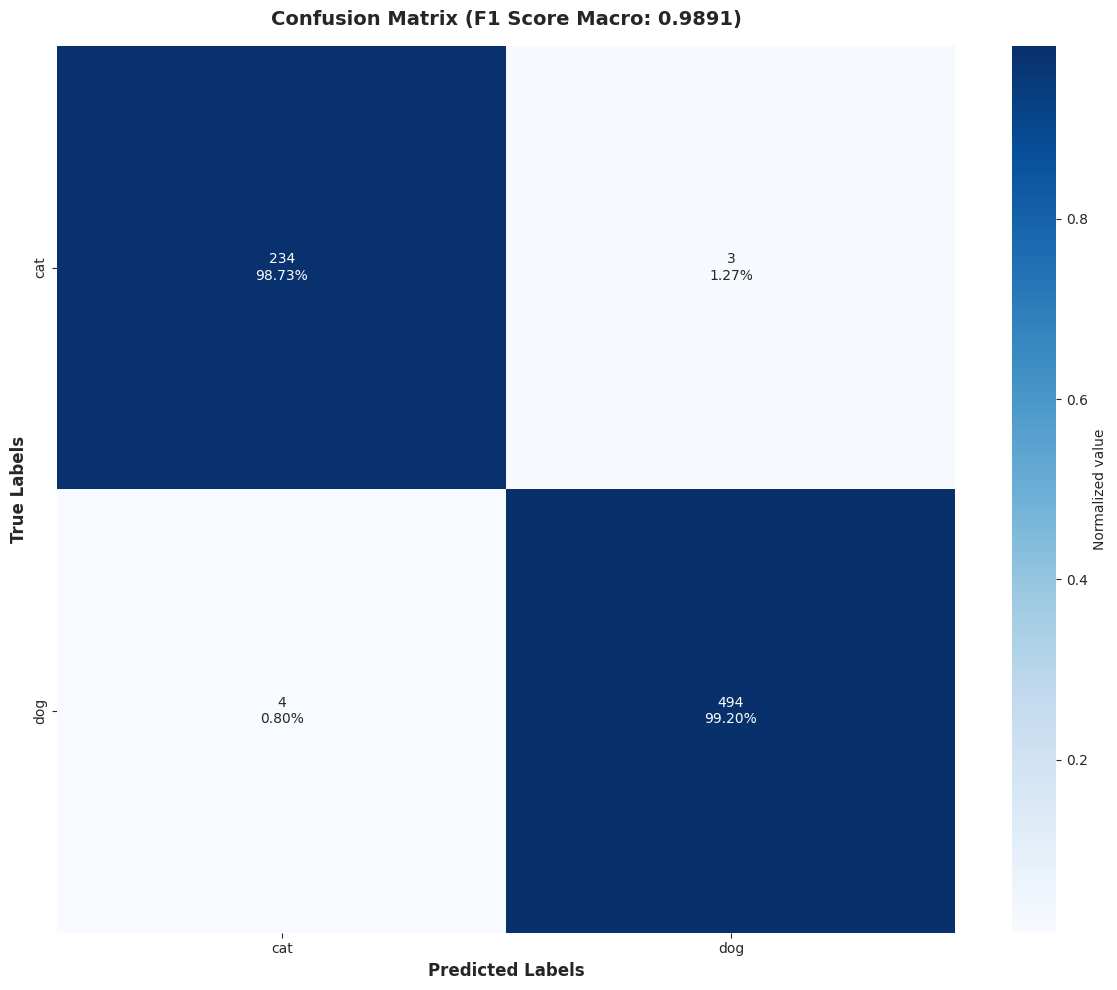

2025/12/14 19:26:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'cats_and_dogs_mobilenet_v2' already exists. Creating a new version of this model...
Created version '2' of model 'cats_and_dogs_mobilenet_v2'.


In [17]:
for lr in [0.05, 0.001]:
    train_and_track_model(
        experiment_name = 'Different Learning Rates for cats_and_dogs',
        run_name = Config.RUN_NAME,
        random_seed = Config.RANDOM_SEED,
        dataset_name = Config.DATASET_NAME,
        dataset_link = Config.DATASET_LINK,
        dataset_labels = Config.DATASET_LABELS,
        model_name = Config.MODEL_NAME,
        model_weights = Config.MODEL_WEIGHTS,
        lr = lr,
        min_delta = Config.MIN_DELTA,
        patience = Config.PATIENCE,
        max_epochs = Config.MAX_EPOCHS,
        batch_size = Config.BATCH_SIZE,
        num_workers = Config.NUM_WORKERS,
        json_path = Config.JSON_PATH,
        csv_path = Config.CSV_PATH
    )

## BATCH SIZE

2025/12/14 19:26:29 INFO mlflow.tracking.fluent: Experiment with name 'Different Batch Sizes for cats_and_dogs' does not exist. Creating a new experiment.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | MobileNetV2 | 2.2 M  | train
----------------------------------------------
2.6 K     Trainable params
2.2 M     Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)
213       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6915


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 23: 'val_loss' reached 0.12064 (best 0.12064), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.12.ckpt' as top 1


Average validation loss for epoch 0: 0.1211
Average training loss for epoch 0: 0.2909


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 46: 'val_loss' reached 0.07764 (best 0.07764), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 1: 0.0782
Average training loss for epoch 1: 0.1021


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 69: 'val_loss' reached 0.06463 (best 0.06463), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=02-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 2: 0.0652
Average training loss for epoch 2: 0.0736


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 92: 'val_loss' reached 0.05464 (best 0.05464), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=03-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 3: 0.0551
Average training loss for epoch 3: 0.0612


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 115: 'val_loss' reached 0.05030 (best 0.05030), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 4: 0.0507
Average training loss for epoch 4: 0.0551


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 138: 'val_loss' reached 0.04817 (best 0.04817), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=05-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 5: 0.0485
Average training loss for epoch 5: 0.0519


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 161: 'val_loss' reached 0.04384 (best 0.04384), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=06-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 6: 0.0443
Average training loss for epoch 6: 0.0489


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 184: 'val_loss' reached 0.03986 (best 0.03986), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=07-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 7: 0.0402
Average training loss for epoch 7: 0.0430


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 207: 'val_loss' reached 0.03758 (best 0.03758), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=08-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 8: 0.0379
Average training loss for epoch 8: 0.0397


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 230: 'val_loss' was not in top 1


Average validation loss for epoch 9: 0.0380
Average training loss for epoch 9: 0.0382


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 253: 'val_loss' reached 0.03721 (best 0.03721), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=10-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 10: 0.0374
Average training loss for epoch 10: 0.0412


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 276: 'val_loss' reached 0.03378 (best 0.03378), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=11-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 11: 0.0340
Average training loss for epoch 11: 0.0362


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 299: 'val_loss' was not in top 1


Average validation loss for epoch 12: 0.0383
Average training loss for epoch 12: 0.0360


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 322: 'val_loss' reached 0.03234 (best 0.03234), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=13-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 13: 0.0325
Average training loss for epoch 13: 0.0336


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 345: 'val_loss' reached 0.03143 (best 0.03143), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=14-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 14: 0.0316
Average training loss for epoch 14: 0.0299


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 368: 'val_loss' reached 0.03098 (best 0.03098), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=15-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 15: 0.0312
Average training loss for epoch 15: 0.0290


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 391: 'val_loss' reached 0.03093 (best 0.03093), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=16-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 16: 0.0310
Average training loss for epoch 16: 0.0302


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 414: 'val_loss' reached 0.02974 (best 0.02974), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=17-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 17: 0.0298
Average training loss for epoch 17: 0.0298


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 18, global step 437: 'val_loss' was not in top 1


Average validation loss for epoch 18: 0.0313
Average training loss for epoch 18: 0.0306


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 19, global step 460: 'val_loss' reached 0.02840 (best 0.02840), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=19-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 19: 0.0285
Average training loss for epoch 19: 0.0268


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 20, global step 483: 'val_loss' was not in top 1


Average validation loss for epoch 20: 0.0315
Average training loss for epoch 20: 0.0285


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 21, global step 506: 'val_loss' reached 0.02781 (best 0.02781), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=21-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 21: 0.0279
Average training loss for epoch 21: 0.0250


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 22, global step 529: 'val_loss' reached 0.02771 (best 0.02771), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=22-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 22: 0.0278
Average training loss for epoch 22: 0.0258


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 23, global step 552: 'val_loss' was not in top 1


Average validation loss for epoch 23: 0.0286
Average training loss for epoch 23: 0.0245


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 24, global step 575: 'val_loss' was not in top 1


Average validation loss for epoch 24: 0.0283
Average training loss for epoch 24: 0.0230


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 25, global step 598: 'val_loss' reached 0.02672 (best 0.02672), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=25-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 25: 0.0268
Average training loss for epoch 25: 0.0249


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 26, global step 621: 'val_loss' was not in top 1


Average validation loss for epoch 26: 0.0290
Average training loss for epoch 26: 0.0236


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 27, global step 644: 'val_loss' was not in top 1


Average validation loss for epoch 27: 0.0272
Average training loss for epoch 27: 0.0243


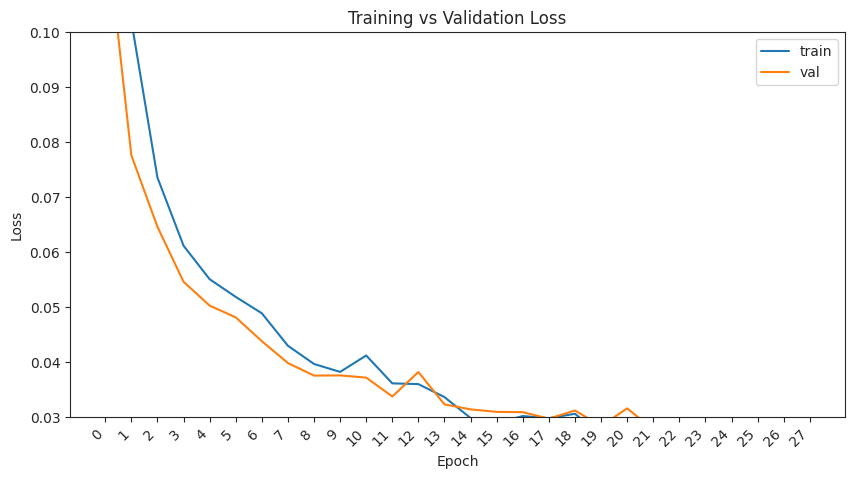

Generating predictions...
F1 Score (macro): 0.9907
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


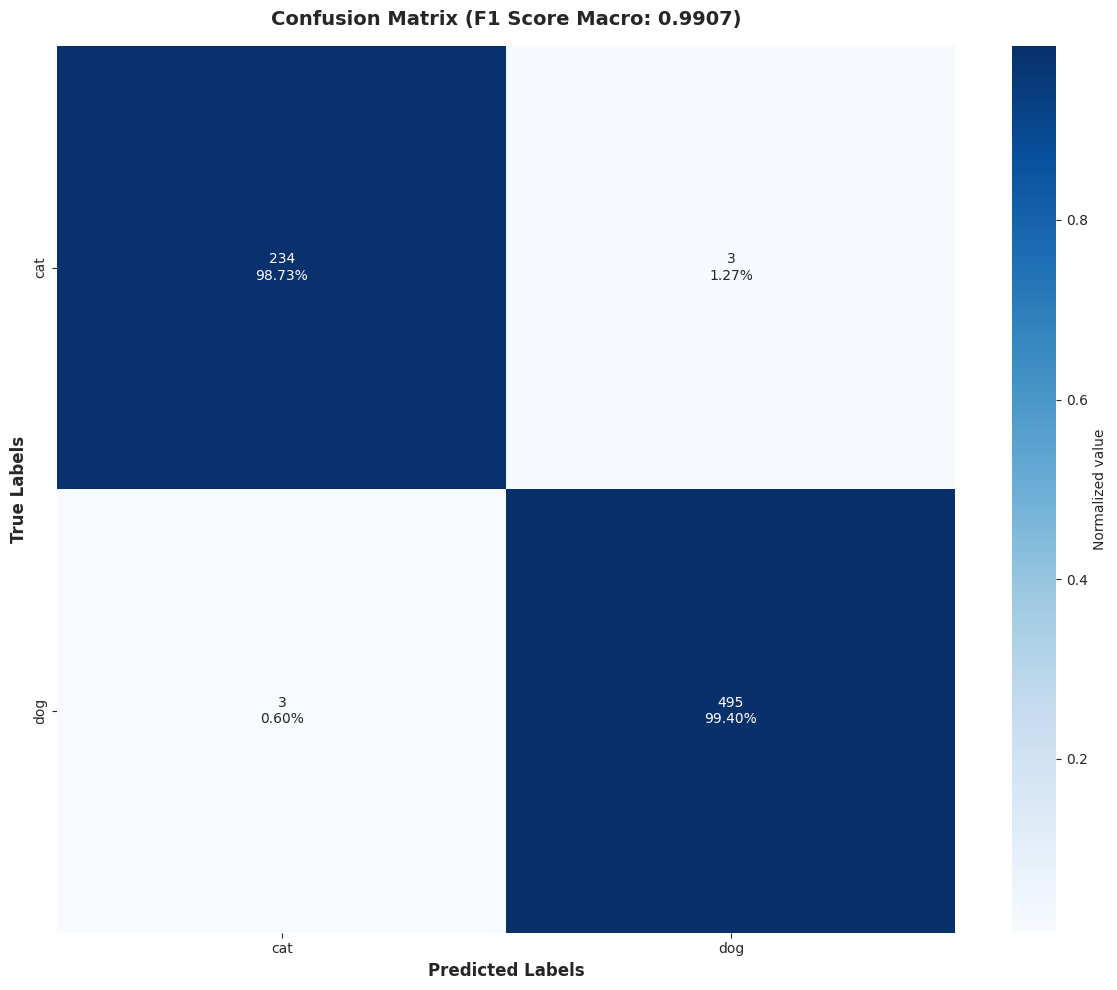

2025/12/14 19:36:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'cats_and_dogs_mobilenet_v2' already exists. Creating a new version of this model...
Created version '3' of model 'cats_and_dogs_mobilenet_v2'.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | MobileNetV2 | 2.2 M  | train
----------------------------------------------
2.6 K     Trainable params
2.2 M     Non-trainable params
2.2 M     Total 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6798


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 12: 'val_loss' reached 0.18921 (best 0.18921), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.19.ckpt' as top 1


Average validation loss for epoch 0: 0.1905
Average training loss for epoch 0: 0.4110


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 24: 'val_loss' reached 0.10931 (best 0.10931), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.11.ckpt' as top 1


Average validation loss for epoch 1: 0.1125
Average training loss for epoch 1: 0.1608


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 36: 'val_loss' reached 0.08402 (best 0.08402), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=02-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 2: 0.0874
Average training loss for epoch 2: 0.1024


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 48: 'val_loss' reached 0.07141 (best 0.07141), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=03-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 3: 0.0748
Average training loss for epoch 3: 0.0794


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 60: 'val_loss' reached 0.06386 (best 0.06386), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 4: 0.0674
Average training loss for epoch 4: 0.0714


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 72: 'val_loss' reached 0.05865 (best 0.05865), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=05-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 5: 0.0619
Average training loss for epoch 5: 0.0630


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 84: 'val_loss' reached 0.05448 (best 0.05448), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=06-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 6: 0.0577
Average training loss for epoch 6: 0.0580


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 96: 'val_loss' reached 0.05118 (best 0.05118), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=07-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 7: 0.0540
Average training loss for epoch 7: 0.0557


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 108: 'val_loss' reached 0.04859 (best 0.04859), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=08-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 8: 0.0516
Average training loss for epoch 8: 0.0523


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 120: 'val_loss' reached 0.04641 (best 0.04641), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=09-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 9: 0.0491
Average training loss for epoch 9: 0.0487


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 132: 'val_loss' reached 0.04463 (best 0.04463), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=10-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 10: 0.0469
Average training loss for epoch 10: 0.0473


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 144: 'val_loss' reached 0.04270 (best 0.04270), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=11-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 11: 0.0451
Average training loss for epoch 11: 0.0442


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 156: 'val_loss' reached 0.04214 (best 0.04214), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=12-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 12: 0.0440
Average training loss for epoch 12: 0.0438


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 168: 'val_loss' reached 0.04114 (best 0.04114), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=13-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 13: 0.0438
Average training loss for epoch 13: 0.0395


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 180: 'val_loss' reached 0.03840 (best 0.03840), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=14-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 14: 0.0404
Average training loss for epoch 14: 0.0387


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 192: 'val_loss' reached 0.03767 (best 0.03767), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=15-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 15: 0.0400
Average training loss for epoch 15: 0.0361


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 204: 'val_loss' reached 0.03652 (best 0.03652), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=16-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 16: 0.0385
Average training loss for epoch 16: 0.0374


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 216: 'val_loss' was not in top 1


Average validation loss for epoch 17: 0.0398
Average training loss for epoch 17: 0.0374


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 18, global step 228: 'val_loss' reached 0.03581 (best 0.03581), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=18-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 18: 0.0372
Average training loss for epoch 18: 0.0348


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 19, global step 240: 'val_loss' was not in top 1


Average validation loss for epoch 19: 0.0380
Average training loss for epoch 19: 0.0330


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 20, global step 252: 'val_loss' reached 0.03509 (best 0.03509), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=20-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 20: 0.0361
Average training loss for epoch 20: 0.0328


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 21, global step 264: 'val_loss' reached 0.03469 (best 0.03469), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=21-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 21: 0.0367
Average training loss for epoch 21: 0.0311


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 22, global step 276: 'val_loss' reached 0.03291 (best 0.03291), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=22-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 22: 0.0342
Average training loss for epoch 22: 0.0317


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 23, global step 288: 'val_loss' reached 0.03245 (best 0.03245), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=23-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 23: 0.0340
Average training loss for epoch 23: 0.0313


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 24, global step 300: 'val_loss' reached 0.03182 (best 0.03182), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=24-val_loss=0.03.ckpt' as top 1


Average validation loss for epoch 24: 0.0333
Average training loss for epoch 24: 0.0295


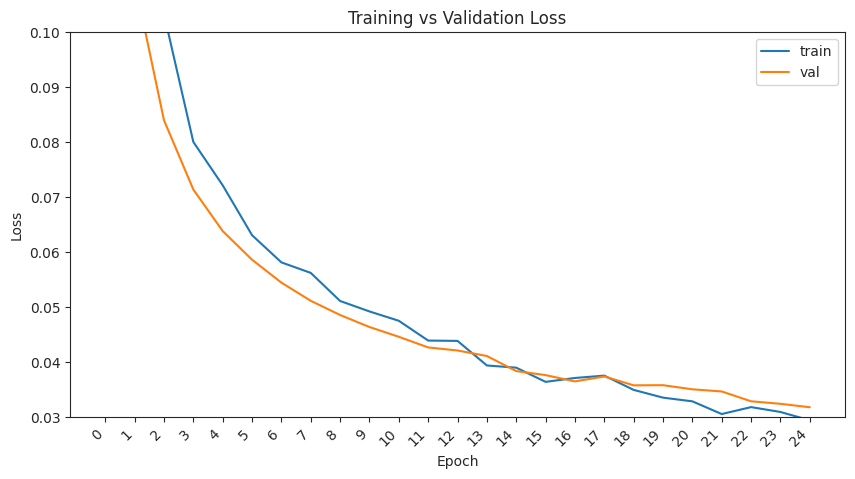

Generating predictions...
F1 Score (macro): 0.9891
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


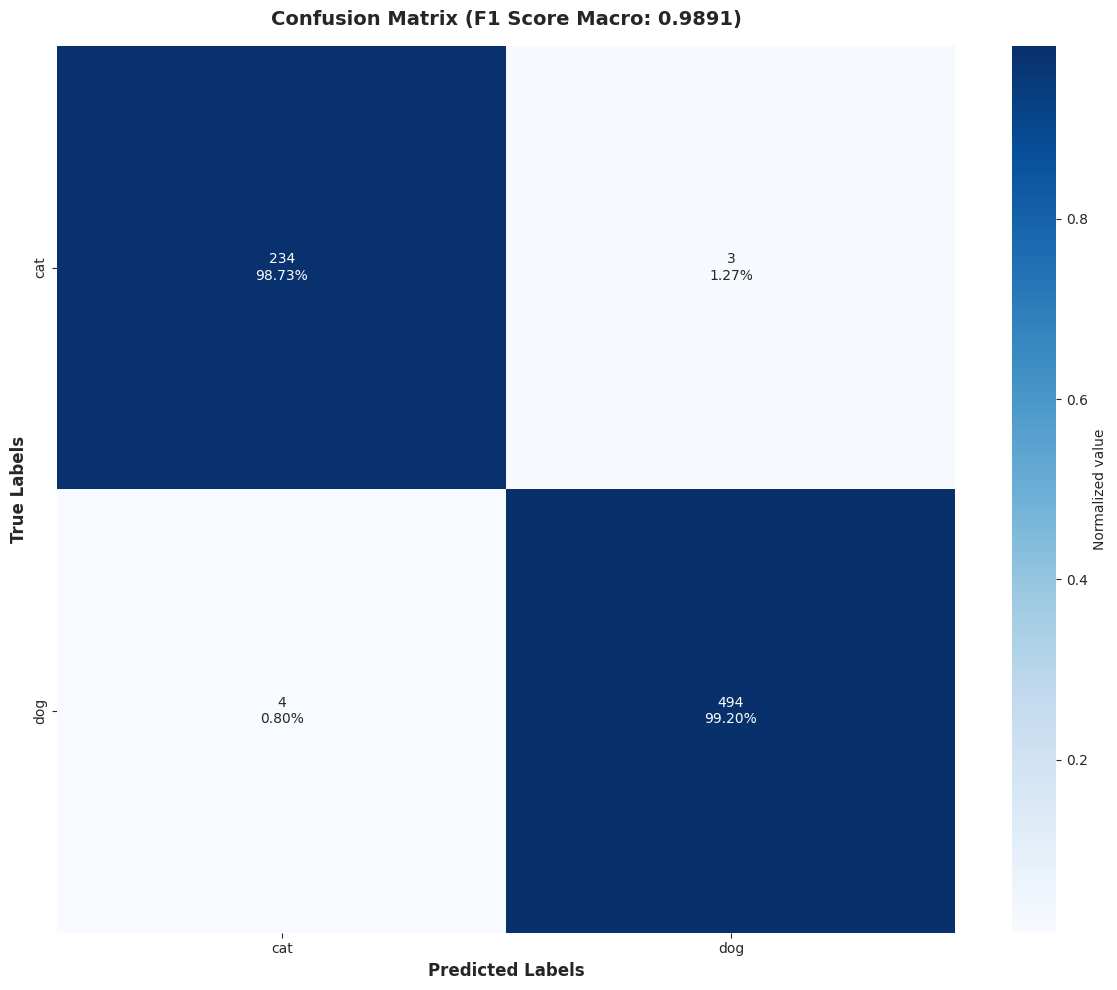

2025/12/14 19:46:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'cats_and_dogs_mobilenet_v2' already exists. Creating a new version of this model...
Created version '4' of model 'cats_and_dogs_mobilenet_v2'.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | MobileNetV2 | 2.2 M  | train
----------------------------------------------
2.6 K     Trainable params
2.2 M     Non-trainable params
2.2 M     Total 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6844


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 6: 'val_loss' reached 0.33412 (best 0.33412), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.33.ckpt' as top 1


Average validation loss for epoch 0: 0.3341
Average training loss for epoch 0: 0.5341


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 12: 'val_loss' reached 0.19145 (best 0.19145), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.19.ckpt' as top 1


Average validation loss for epoch 1: 0.1914
Average training loss for epoch 1: 0.2843


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 18: 'val_loss' reached 0.13892 (best 0.13892), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=02-val_loss=0.14.ckpt' as top 1


Average validation loss for epoch 2: 0.1389
Average training loss for epoch 2: 0.1816


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 24: 'val_loss' reached 0.10978 (best 0.10978), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=03-val_loss=0.11.ckpt' as top 1


Average validation loss for epoch 3: 0.1098
Average training loss for epoch 3: 0.1332


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 30: 'val_loss' reached 0.09494 (best 0.09494), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.09.ckpt' as top 1


Average validation loss for epoch 4: 0.0949
Average training loss for epoch 4: 0.1094


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 36: 'val_loss' reached 0.08497 (best 0.08497), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=05-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 5: 0.0850
Average training loss for epoch 5: 0.0927


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 42: 'val_loss' reached 0.07718 (best 0.07718), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=06-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 6: 0.0772
Average training loss for epoch 6: 0.0828


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 48: 'val_loss' reached 0.07218 (best 0.07218), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=07-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 7: 0.0722
Average training loss for epoch 7: 0.0766


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 54: 'val_loss' reached 0.06796 (best 0.06796), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=08-val_loss=0.07.ckpt' as top 1


Average validation loss for epoch 8: 0.0680
Average training loss for epoch 8: 0.0716


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 60: 'val_loss' reached 0.06396 (best 0.06396), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=09-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 9: 0.0640
Average training loss for epoch 9: 0.0677


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 66: 'val_loss' reached 0.06168 (best 0.06168), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=10-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 10: 0.0617
Average training loss for epoch 10: 0.0633


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 72: 'val_loss' reached 0.05886 (best 0.05886), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=11-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 11: 0.0589
Average training loss for epoch 11: 0.0613


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 78: 'val_loss' reached 0.05640 (best 0.05640), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=12-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 12: 0.0564
Average training loss for epoch 12: 0.0589


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 84: 'val_loss' reached 0.05460 (best 0.05460), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=13-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 13: 0.0546
Average training loss for epoch 13: 0.0554


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 90: 'val_loss' reached 0.05277 (best 0.05277), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=14-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 14: 0.0528
Average training loss for epoch 14: 0.0537


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 96: 'val_loss' reached 0.05114 (best 0.05114), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=15-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 15: 0.0511
Average training loss for epoch 15: 0.0510


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 102: 'val_loss' reached 0.05023 (best 0.05023), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=16-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 16: 0.0502
Average training loss for epoch 16: 0.0507


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 108: 'val_loss' reached 0.04857 (best 0.04857), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=17-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 17: 0.0486
Average training loss for epoch 17: 0.0503


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 18, global step 114: 'val_loss' reached 0.04733 (best 0.04733), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=18-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 18: 0.0473
Average training loss for epoch 18: 0.0504


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 19, global step 120: 'val_loss' reached 0.04621 (best 0.04621), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=19-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 19: 0.0462
Average training loss for epoch 19: 0.0465


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 20, global step 126: 'val_loss' reached 0.04524 (best 0.04524), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=20-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 20: 0.0452
Average training loss for epoch 20: 0.0453


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 21, global step 132: 'val_loss' reached 0.04441 (best 0.04441), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=21-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 21: 0.0444
Average training loss for epoch 21: 0.0457


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 22, global step 138: 'val_loss' reached 0.04358 (best 0.04358), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=22-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 22: 0.0436
Average training loss for epoch 22: 0.0427


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 23, global step 144: 'val_loss' reached 0.04273 (best 0.04273), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=23-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 23: 0.0427
Average training loss for epoch 23: 0.0424


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 24, global step 150: 'val_loss' reached 0.04185 (best 0.04185), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=24-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 24: 0.0419
Average training loss for epoch 24: 0.0408


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 25, global step 156: 'val_loss' reached 0.04118 (best 0.04118), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=25-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 25: 0.0412
Average training loss for epoch 25: 0.0408


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 26, global step 162: 'val_loss' reached 0.04048 (best 0.04048), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=26-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 26: 0.0405
Average training loss for epoch 26: 0.0415


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 27, global step 168: 'val_loss' reached 0.03979 (best 0.03979), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=27-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 27: 0.0398
Average training loss for epoch 27: 0.0382


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 28, global step 174: 'val_loss' reached 0.03919 (best 0.03919), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=28-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 28: 0.0392
Average training loss for epoch 28: 0.0376


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 29, global step 180: 'val_loss' reached 0.03857 (best 0.03857), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=29-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 29: 0.0386
Average training loss for epoch 29: 0.0375


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 30, global step 186: 'val_loss' reached 0.03807 (best 0.03807), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=30-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 30: 0.0381
Average training loss for epoch 30: 0.0375


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 31, global step 192: 'val_loss' reached 0.03767 (best 0.03767), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=31-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 31: 0.0377
Average training loss for epoch 31: 0.0362


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 32, global step 198: 'val_loss' reached 0.03715 (best 0.03715), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=32-val_loss=0.04.ckpt' as top 1


Average validation loss for epoch 32: 0.0372
Average training loss for epoch 32: 0.0366


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 33, global step 204: 'val_loss' reached 0.03667 (best 0.03667), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=33-val_loss=0.04-v1.ckpt' as top 1


Average validation loss for epoch 33: 0.0367
Average training loss for epoch 33: 0.0352


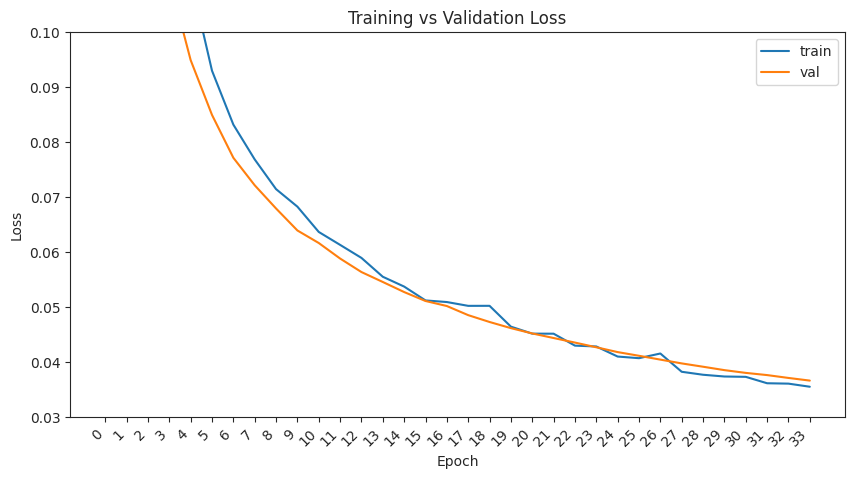

Generating predictions...
F1 Score (macro): 0.9891
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


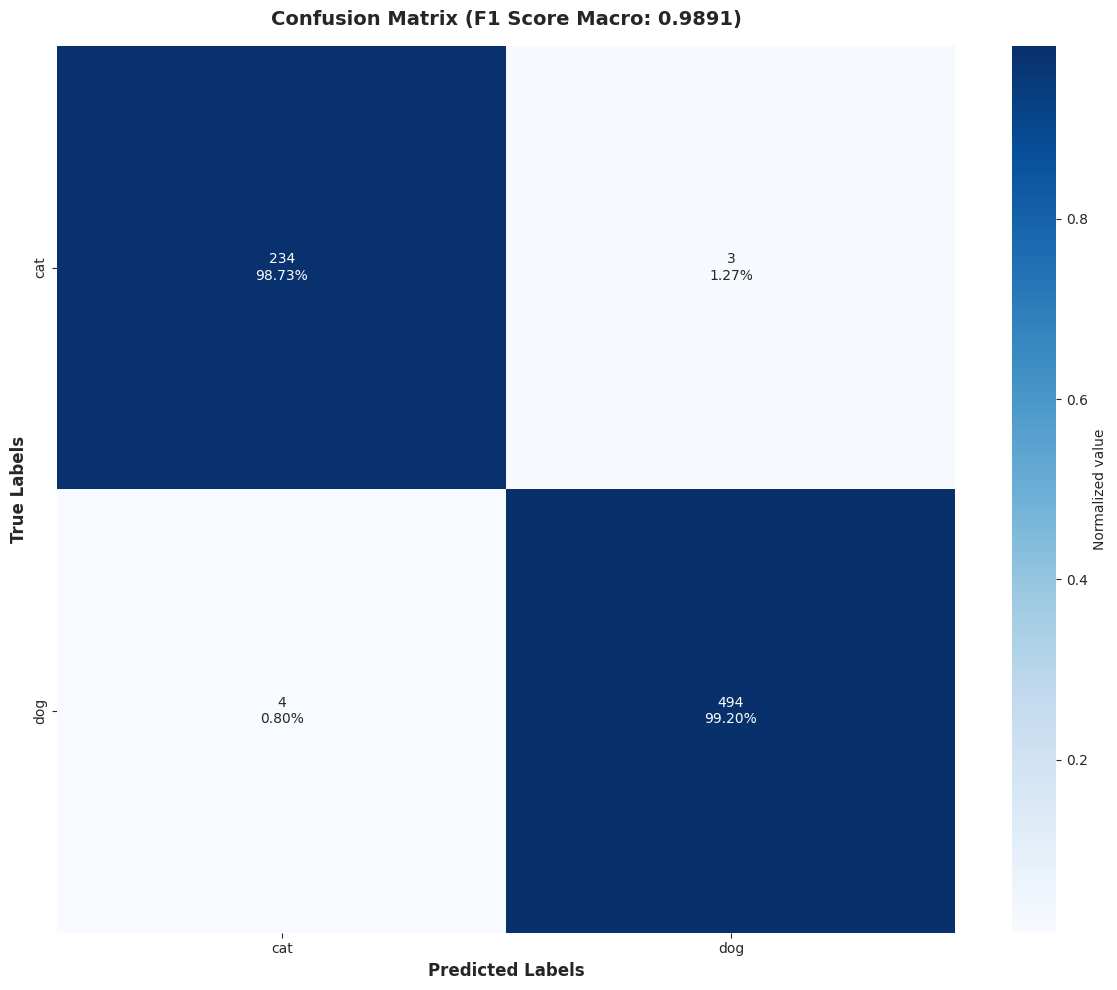

2025/12/14 19:59:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'cats_and_dogs_mobilenet_v2' already exists. Creating a new version of this model...
Created version '5' of model 'cats_and_dogs_mobilenet_v2'.


In [18]:
for batch_size in [256, 512, 1024]:
    train_and_track_model(
        experiment_name = 'Different Batch Sizes for cats_and_dogs',
        run_name = Config.RUN_NAME,
        random_seed = Config.RANDOM_SEED,
        dataset_name = Config.DATASET_NAME,
        dataset_link = Config.DATASET_LINK,
        dataset_labels = Config.DATASET_LABELS,
        model_name = Config.MODEL_NAME,
        model_weights = Config.MODEL_WEIGHTS,
        lr = Config.LR,
        min_delta = Config.MIN_DELTA,
        patience = Config.PATIENCE,
        max_epochs = Config.MAX_EPOCHS,
        batch_size = batch_size,
        num_workers = Config.NUM_WORKERS,
        json_path = Config.JSON_PATH,
        csv_path = Config.CSV_PATH
    )

## BOTH: LR + BATCH SIZE

2025/12/14 20:50:01 INFO mlflow.tracking.fluent: Experiment with name 'Best LR + Batches for cats_and_dogs' does not exist. Creating a new experiment.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | MobileNetV2 | 2.2 M  | train
----------------------------------------------
2.6 K     Trainable params
2.2 M     Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)
213       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.6915


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 23: 'val_loss' reached 0.26979 (best 0.26979), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=00-val_loss=0.27.ckpt' as top 1


Average validation loss for epoch 0: 0.2777
Average training loss for epoch 0: 1.0238


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 46: 'val_loss' reached 0.10832 (best 0.10832), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=01-val_loss=0.11.ckpt' as top 1


Average validation loss for epoch 1: 0.1086
Average training loss for epoch 1: 0.1831


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 69: 'val_loss' reached 0.10075 (best 0.10075), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=02-val_loss=0.10.ckpt' as top 1


Average validation loss for epoch 2: 0.1027
Average training loss for epoch 2: 0.0979


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 92: 'val_loss' reached 0.07889 (best 0.07889), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=03-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 3: 0.0802
Average training loss for epoch 3: 0.0731


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 115: 'val_loss' reached 0.07877 (best 0.07877), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=04-val_loss=0.08.ckpt' as top 1


Average validation loss for epoch 4: 0.0777
Average training loss for epoch 4: 0.0663


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 138: 'val_loss' reached 0.05947 (best 0.05947), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=05-val_loss=0.06.ckpt' as top 1


Average validation loss for epoch 5: 0.0587
Average training loss for epoch 5: 0.0556


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 161: 'val_loss' reached 0.05183 (best 0.05183), saving model to '/home/alumno/Desktop/datos/MLOPS/lab3_model/cats_and_dogs_mobilenet_v2_checkpoints/cats_and_dogs_mobilenet_v2-epoch=06-val_loss=0.05.ckpt' as top 1


Average validation loss for epoch 6: 0.0517
Average training loss for epoch 6: 0.0525


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 184: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.0924
Average training loss for epoch 7: 0.0482


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 207: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.0598
Average training loss for epoch 8: 0.0382


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 230: 'val_loss' was not in top 1


Average validation loss for epoch 9: 0.0664
Average training loss for epoch 9: 0.0417


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 253: 'val_loss' was not in top 1


Average validation loss for epoch 10: 0.0968
Average training loss for epoch 10: 0.0428


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 276: 'val_loss' was not in top 1


Average validation loss for epoch 11: 0.0932
Average training loss for epoch 11: 0.0392


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 299: 'val_loss' was not in top 1


Average validation loss for epoch 12: 0.0567
Average training loss for epoch 12: 0.0626


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 322: 'val_loss' was not in top 1


Average validation loss for epoch 13: 0.0561
Average training loss for epoch 13: 0.0238


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 345: 'val_loss' was not in top 1


Average validation loss for epoch 14: 0.0566
Average training loss for epoch 14: 0.0218


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 368: 'val_loss' was not in top 1


Average validation loss for epoch 15: 0.0569
Average training loss for epoch 15: 0.0171


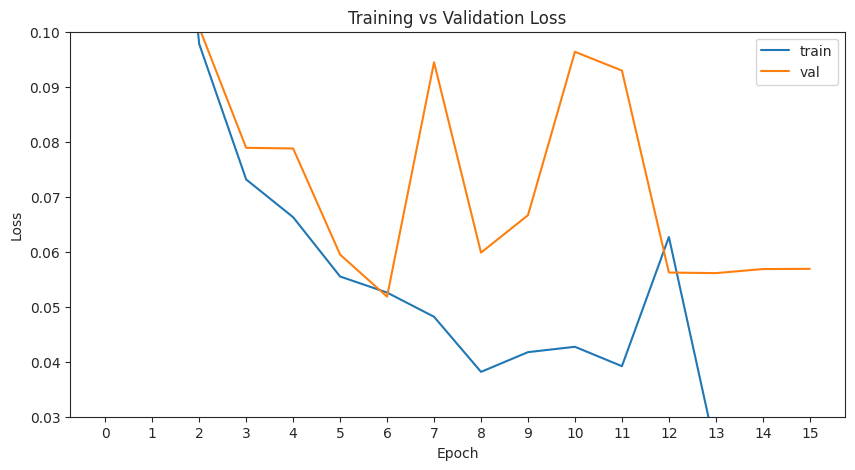

Generating predictions...
F1 Score (macro): 0.9875
Confusion matrix saved to /home/alumno/Desktop/datos/MLOPS/lab3_model/figures/cats_and_dogs_mobilenet_v2_confusion_matrix.pdf


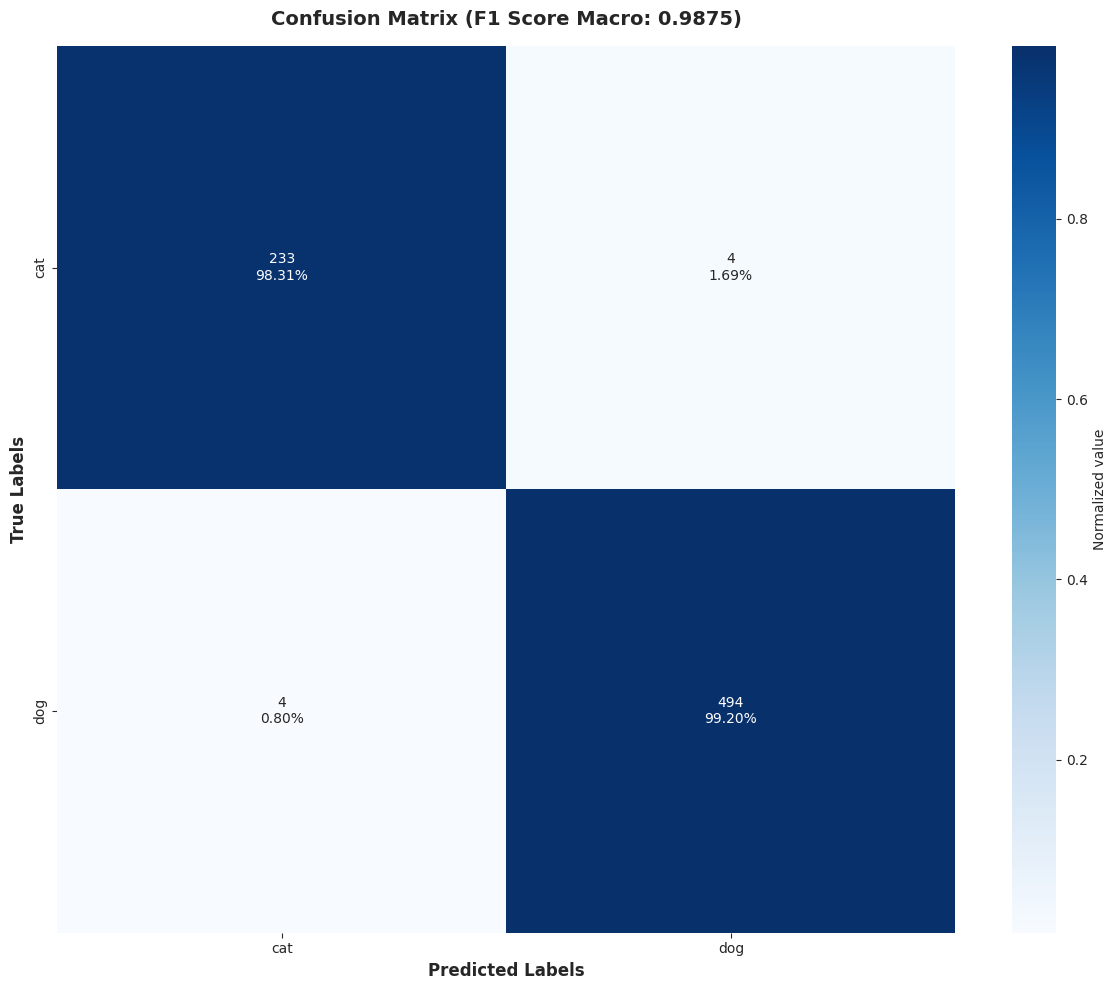

2025/12/14 20:55:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'cats_and_dogs_mobilenet_v2' already exists. Creating a new version of this model...
Created version '6' of model 'cats_and_dogs_mobilenet_v2'.


In [20]:
train_and_track_model(
    experiment_name = 'Best LR + Batches for cats_and_dogs',
    run_name = Config.RUN_NAME,
    random_seed = Config.RANDOM_SEED,
    dataset_name = Config.DATASET_NAME,
    dataset_link = Config.DATASET_LINK,
    dataset_labels = Config.DATASET_LABELS,
    model_name = Config.MODEL_NAME,
    model_weights = Config.MODEL_WEIGHTS,
    lr = 0.05,
    min_delta = Config.MIN_DELTA,
    patience = Config.PATIENCE,
    max_epochs = Config.MAX_EPOCHS,
    batch_size = 256,
    num_workers = Config.NUM_WORKERS,
    json_path = Config.JSON_PATH,
    csv_path = Config.CSV_PATH
)

# End of Notebook (Shortcut)